# **Loading Libraries**

In [ ]:
%pip install scipy icecream

In [ ]:
import seaborn as sns
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt


from scipy.optimize import linprog
from icecream import ic

# **Building a task plot**

In [ ]:
sns.set_theme(style="darkgrid")

In [ ]:
N_1 = 375
N_2 = 300

x_eq = np.arange(N_2+1)
x_ineq = np.arange(N_1+1)

y_eq = 300 - x_eq
y_ineq = (375 - x_ineq) / 2

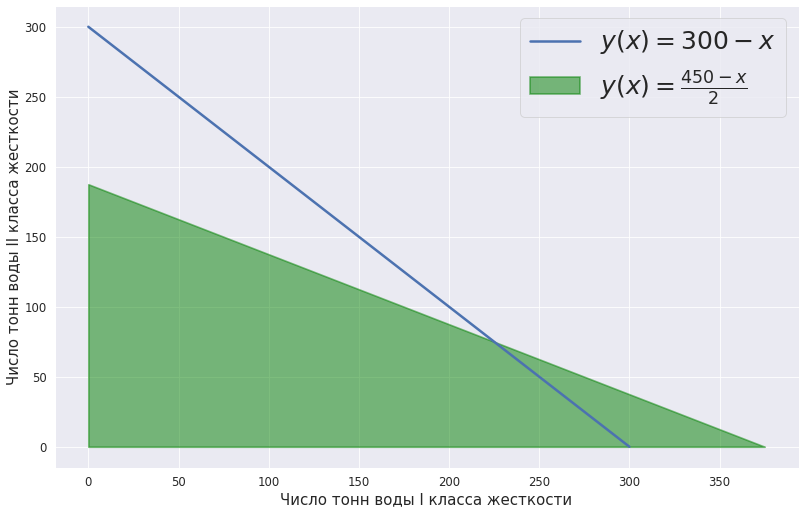

In [ ]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(x_eq, y_eq, linewidth=3, label=r'$y(x)=300-x$')
plt.fill_between(x_ineq, y_ineq, facecolor='g', alpha=0.5, color='green', linewidth=2, label=r'$y(x)=\frac{450-x}{2}$')

plt.xlabel('Число тонн воды I класса жесткости', fontsize=18)
plt.ylabel('Число тонн воды II класса жесткости', fontsize=18)
plt.xticks(fontsize=14, fontweight=500)
plt.yticks(fontsize=14, fontweight=500)
plt.legend(loc='best', fontsize=30)
plt.grid(True)
plt.show()

# **Implementation with SciPy**

N.B.
*linprog()* решает только задачи минимизации (не максимизации) и **не допускает** ограничений-неравенств со знаком больше или равно (≥).

In [44]:
obj = [8, 6]

left_side_ineq = [[1, 2]]
right_side_ineq = [375]

left_side_eq = [[1, 1]]
right_side_eq = [300]

bnd = [(0, float("inf")),
       (0, float("inf"))]

In [45]:
opt_ans = linprog(c=obj, A_ub=left_side_ineq, b_ub=right_side_ineq,
              A_eq=left_side_eq, b_eq=right_side_eq, bounds=bnd,
              method="revised simplex")

<ipython-input-45-ad7c346605c2>:1: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  opt_ans = linprog(c=obj, A_ub=left_side_ineq, b_ub=right_side_ineq,


In [46]:
opt_ans

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 2250.0
       x: [ 2.250e+02  7.500e+01]
     nit: 2

## **Result images**

In [47]:
N_1 = 375
N_2 = 300

x_eq = np.arange(N_2+1)
x_ineq = np.arange(N_1+1)

y_eq = 300 - x_eq
y_ineq = (375 - x_ineq) / 2

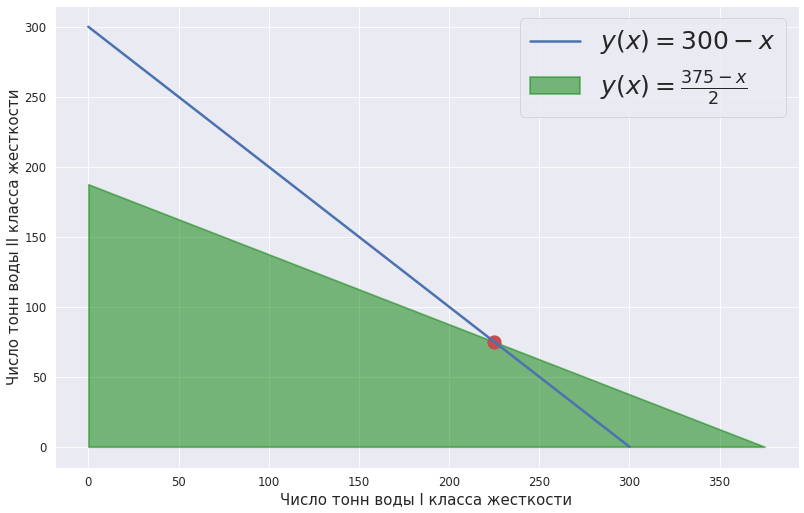

In [48]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(x_eq, y_eq, linewidth=3, label=r'$y(x)=300-x$')
plt.fill_between(x_ineq, y_ineq, facecolor='g', alpha=0.5, color='green', linewidth=2, label=r'$y(x)=\frac{375-x}{2}$')
plt.scatter(opt_ans.x[0], opt_ans.x[1], c ="r", linewidths=3, s = 200)

plt.xlabel('Число тонн воды I класса жесткости', fontsize=18)
plt.ylabel('Число тонн воды II класса жесткости', fontsize=18)
plt.xticks(fontsize=14, fontweight=500)
plt.yticks(fontsize=14, fontweight=500)
plt.legend(loc='best', fontsize=30)
plt.grid(True)
plt.show()

# **Manual implementation**

In [ ]:
def convetr_to_simplex_table(c, A, b):
  xb = [eqn + [x] for eqn, x in zip(A, b)]
  z = c + [0]

  return xb + [z]

In [ ]:
def check(simplex_table):
  z = simplex_table[-1]

  return any(x != 0 for x in z[:-1])

In [ ]:
def get_pivot_point(simplex_table):
  z = simplex_table[-1]
  column =  [i for i, x in enumerate(z[:-1]) if x != 0][0]

  restrictions = []
  for eqn in simplex_table[:-1]:
      element = eqn[column]

      restrictions.append(math.inf if element <= 0 else eqn[-1] / element)

  row = restrictions.index(min(restrictions))

  return row, column

In [ ]:
def rotate_simplex_table(simplex_table, pivot_point):
  new_simplex_table = [[] for eqn in simplex_table]

  i, j = pivot_point

  pivot_value = simplex_table[i][j]

  new_simplex_table[i] = np.array(simplex_table[i]) / pivot_value

  for eqn_index, eqn in enumerate(simplex_table):
      if eqn_index != i:
          multiplier = np.array(new_simplex_table[i]) * simplex_table[eqn_index][j]
          new_simplex_table[eqn_index] = np.array(simplex_table[eqn_index]) - multiplier

  return new_simplex_table

In [ ]:
def check_basic_var(column):
  return sum(column) == 1 and len([col for col in column if col == 0]) == len(column) - 1

In [ ]:
def get_solution(simplex_table):
  columns = np.array(simplex_table).T

  solutions = []
  for column in columns[:-1]:
    solution = 0
    if check_basic_var(column):
      one_index = column.tolist().index(1)
      solution = columns[-1][one_index]
    solutions.append(solution)

  return solutions

In [ ]:
def visualize_tableau(simplex_table):
  df = pd.DataFrame(simplex_table)

  ic(df)
  print()

In [ ]:
def simplex(c, A, b):
  simplex_table = convetr_to_simplex_table(c, A, b)

  visualize_tableau(simplex_table)

  while check(simplex_table):
    pivot_point = get_pivot_point(simplex_table)
    simplex_table = rotate_simplex_table(simplex_table, pivot_point)

    visualize_tableau(simplex_table)

    if simplex_table[-1][-2] != 0:
      break

  x, y, z = get_solution(simplex_table)

  print(f'Result:\nx = {x}, y = {y};\nF(x,y) = {c[0] * x + c[1] * y}')

  return (x, y, )

In [55]:
c = [8.0, 6.0, 0.0]
A = [[1.0, 1.0, 0.0],
    [1.0, 2.0, 0.0]]

b = [300.0, 375.0]

In [56]:
x, y = simplex(c, A, b)

ic| df:      0    1    2      3
        0  1.0  1.0  0.0  300.0
        1  1.0  2.0  0.0  375.0
        2  8.0  6.0  0.0    0.0
ic| df:      0    1    2       3
        0  1.0  1.0  0.0   300.0
        1  0.0  1.0  0.0    75.0
        2  0.0 -2.0  0.0 -2400.0
ic| df:      0    1    2       3
        0  1.0  0.0  0.0   225.0
        1  0.0  1.0  0.0    75.0
        2  0.0  0.0  0.0 -2250.0





Result:
x = 225.0, y = 75.0;
F(x,y) = 2250.0


## **Result images**

In [59]:
N_1 = 300
N_2 = 375

x_eq = np.arange(N_1+1)
x_ineq = np.arange(N_2+1)

y_eq = 300 - x_eq
y_ineq = (375 - x_ineq) / 2

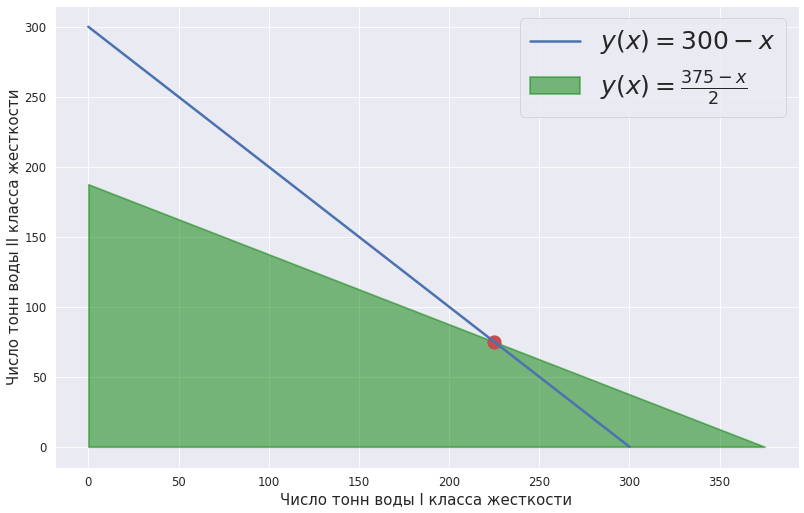

In [60]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(x_eq, y_eq, linewidth=3, label=r'$y(x)=300-x$')
plt.fill_between(x_ineq, y_ineq, facecolor='g', alpha=0.5, color='green', linewidth=2, label=r'$y(x)=\frac{375-x}{2}$')
plt.scatter(x, y, c ="r", linewidths=3, s = 200)

plt.xlabel('Число тонн воды I класса жесткости', fontsize=18)
plt.ylabel('Число тонн воды II класса жесткости', fontsize=18)
plt.xticks(fontsize=14, fontweight=500)
plt.yticks(fontsize=14, fontweight=500)
plt.legend(loc='best', fontsize=30)
plt.grid(True)
plt.show()